**Loading Final dataframe**

In [0]:
import pandas as pd
data=pd.read_csv("/content/drive/My Drive/data_final(reddit)")

In [34]:
data

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,author,authors,body,comment,comms_num,created,flair,id,score,title,url
0,0,0,0,dhavalcoholic,ICICIPruLifeIns,reposting lack activity r askindiahello last y...,dear policy holder dhavalcoholic request help ...,1,1.386254e+09,AskIndia,1s57oi,1,need feedback insurance policy took xpost aski...,https://www.reddit.com/r/india/comments/1s57oi...
1,1,1,1,amitkumarthakur,RAD-Business RAD-Business None barcam10 _snor...,24hrs local police station register case dont ...,calm downgo sp office town file grievance imme...,24,1.554080e+09,AskIndia,b7pvwt,94,somebody want kill full family,https://www.reddit.com/r/india/comments/b7pvwt...
2,2,2,2,FrustratedOCIHopeful,plshelpthedog ayyylmaaaoo Proper_Boysenberry ...,hello askindia first time poster long time lur...,honestly supervisor behaved exactly government...,27,1.555361e+09,AskIndia,bdfid1,10,ambassador india takes back newly issued oci c...,https://www.reddit.com/r/india/comments/bdfid1...
3,3,3,3,aloo_vs_bhaloo,vcdarklord tilismilis aloo_vs_bhaloo dogaa fo...,r tooafraidtoask india edition,modi control sex desires jerk someone else pro...,22,1.566529e+09,AskIndia,cu1xn4,18,randians afraid ask,https://www.reddit.com/r/india/comments/cu1xn4...
4,4,4,4,multubunu,,hello submitted r raskindia week ago got answe...,,0,1.361085e+09,AskIndia,18ntue,0,askindia cingari cengar tzengar,https://www.reddit.com/r/india/comments/18ntue...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3555,2425,,,AlternativeDrop6,jnik27promiscuous_bhismaKemosahbeolololopololo...,,Bc dunia khtm hogi is saal lagta haiThe resear...,35,1.586954e+09,Coronavirus,g1l2lv,138,Coronavirus Mutation Found in India “Raises Al...,https://weather.com/en-IN/india/coronavirus/ne...
3556,2426,,,Dumma1729,qwertyzxcvbnmpoiuy-The-Bat-budbukAnxiousBlocka...,,Because as the great George Carlin once said -...,26,1.587671e+09,Coronavirus,g6l7hl,85,"As India’s Poor Demand Relief, Why Are Middle ...",https://www.newsclick.in/India-Poor-Demand-Rel...
3557,2427,,,GL4389,BhayanakMuutabd_min_ibadillahKemosahbeTimbaktu...,,> None of them have shown any symptoms of Covi...,18,1.587410e+09,Coronavirus,g4qvfx,153,"Out of money, 6 foreigners make home inside ca...",https://www.hindustantimes.com/india-news/out-...
3558,2428,,,n1ght_w1ng08,vindicators_riseKissMyBBQMAA_KI_CHUDIYAmrfreez...,,The other day I saw a video where business was...,36,1.586001e+09,Coronavirus,fumux8,573,Doctors say India must prepare for an 'onslaug...,https://edition.cnn.com/2020/04/03/asia/india-...


**While scrapping data I noticed that a request of 500 posts from each flair using PRAW didn't actually return 500 posts .**

**For analysis purpose , let's see the the exact number of posts per flair in our dataset**

AskIndia  -->  342
Non-Political  -->  353
[R]eddiquette  -->  0
Scheduled  -->  350
Photography  -->  343
Science/Technology  -->  343
Politics  -->  353
Business/Finance  -->  344
Policy/Economy  -->  344
Sports  -->  310
Food  -->  112
AMA  -->  98
Coronavirus  -->  249


Text(0.5, 0, 'FLAIR')

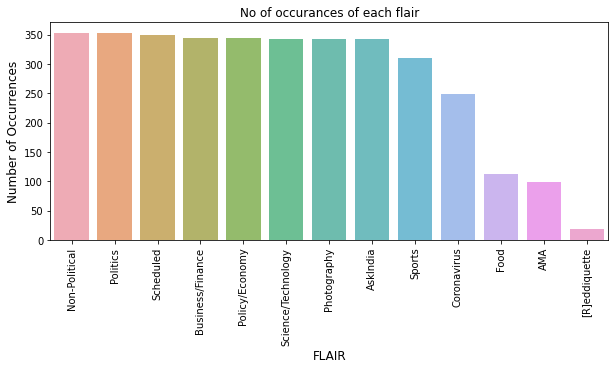

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
cnt = data['flair'].value_counts()


flairs = [ "AskIndia", "Non-Political", "[R]eddiquette",
          "Scheduled", "Photography", "Science/Technology",
          "Politics", "Business/Finance", "Policy/Economy",
          "Sports", "Food", "AMA" ,"Coronavirus"]

for i in flairs:
    print(i, " --> " ,int(data.flair.str.count(i).sum()))



plt.figure(figsize=(10,4))
sns.barplot(cnt.index, cnt.values, alpha=0.8)

plt.title("No of occurances of each flair")
plt.xticks(rotation=90)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('FLAIR', fontsize=12)

**It's pretty clear that our dataset is imbalanced due to less number of posts for flairs [AMA,Food,[R]eddiquette]**

**Besides, the problem is that models trained on unbalanced datasets often have poor results when they have to generalize (predict a class or classify unseen observations).**

So we cannot rely on accuracy as a good performance metric due to something called as **Accuracy Paradox**

It is the case where your accuracy measures tell the story that you have excellent accuracy (such as 90%), but the accuracy is only reflecting the underlying class distribution ie you are not performing well on every class rather you are performing good on the class with maximum occurence in your dataset

So, I will look for other metrics like precision ,recall,F1 score in the classifiaction report .

In [36]:


data.describe()  #helps us to get an overview of data

,Unnamed: 0,comms_num,created,score
count,3560.000000,3560.000000,3.560000e+03,3560.000000
mean,830.284270,132.216011,1.564104e+09,291.259270
std,620.542123,435.508558,4.076408e+07,777.397532
min,0.000000,0.000000,1.305894e+09,0.000000
25%,362.750000,7.000000,1.562239e+09,17.000000
50%,693.000000,24.000000,1.583163e+09,54.000000
75%,1090.250000,69.000000,1.586449e+09,223.000000
max,2429.000000,10798.000000,1.587825e+09,17902.000000


**Using Word clouds to get an actual sense of textual data in terms of frequently occuring words** 

Word clouds can identify trends and patterns that would otherwise be unclear or difficult to see in a tabular format.

Frequently used keywords stand out better in a word cloud. Common words that might be overlooked in tabular form are highlighted in larger text making them pop out when displayed in a word cloud.

They are an effective method for analyzing text-data.

**Word Cloud for each flair**



In [0]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)


def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 
    ).generate(str(data))
    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud)
    plt.show()



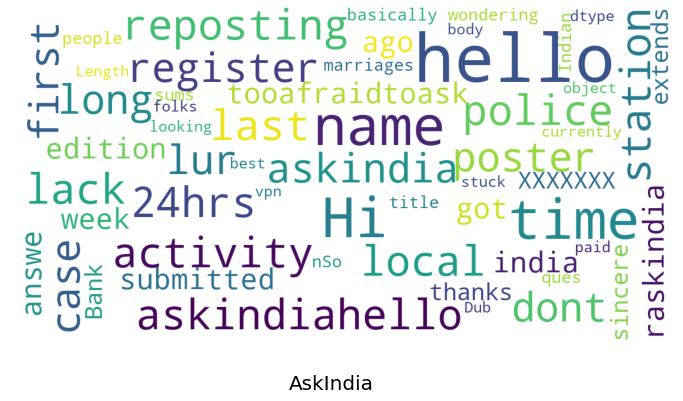

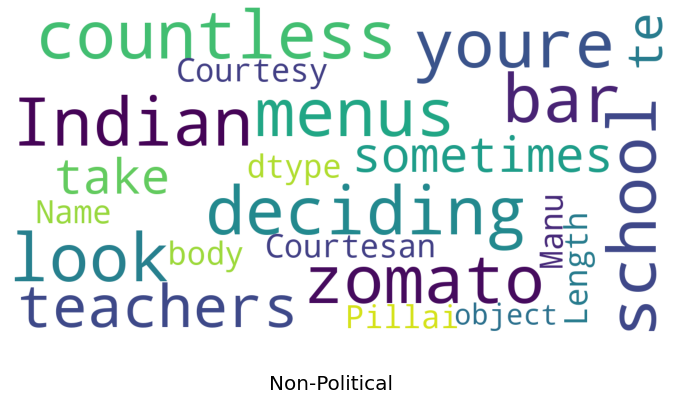

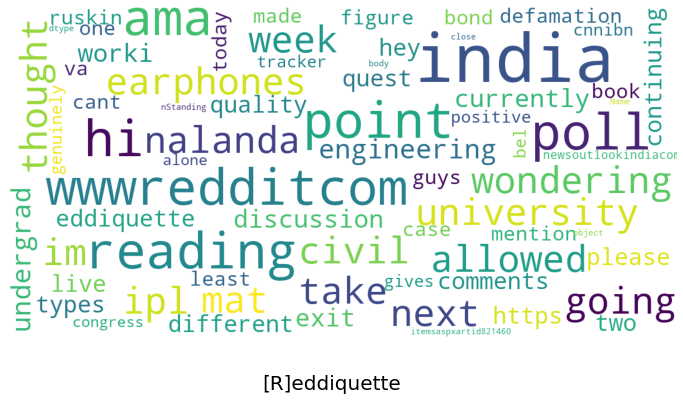

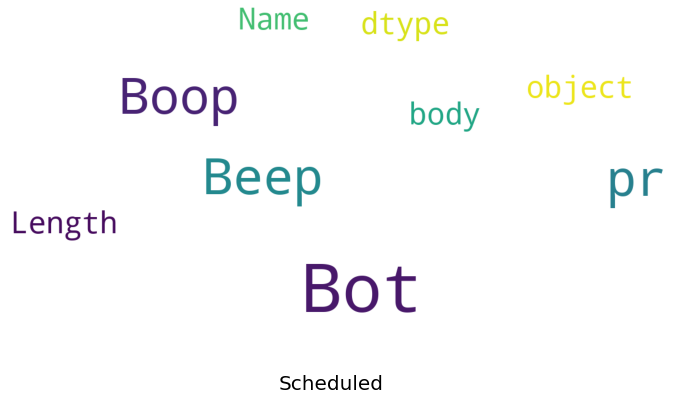

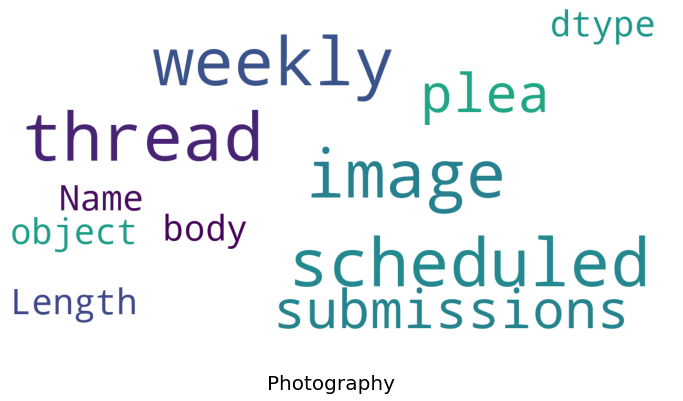

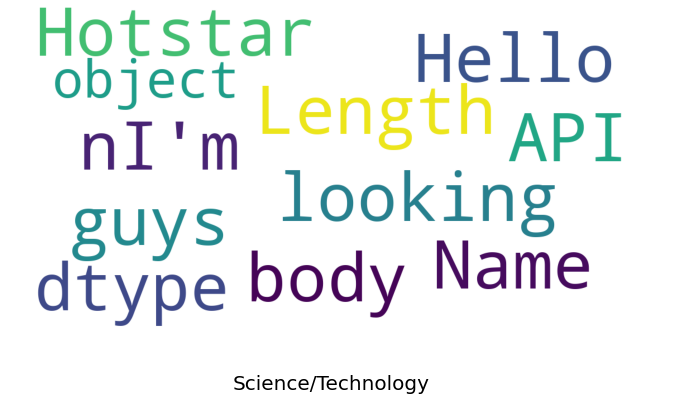

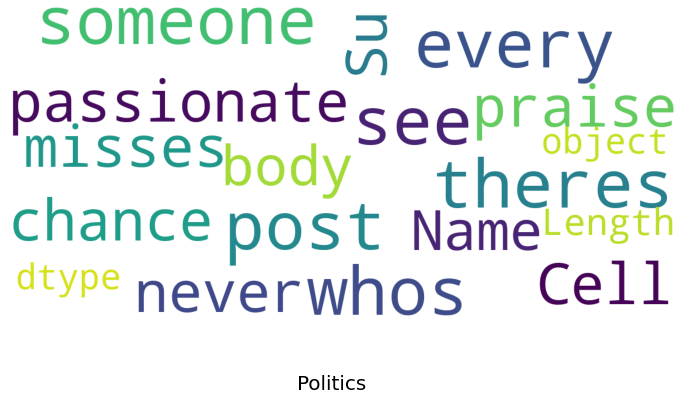

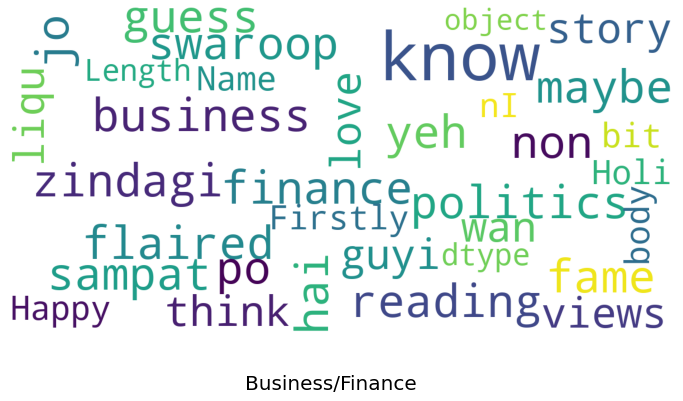

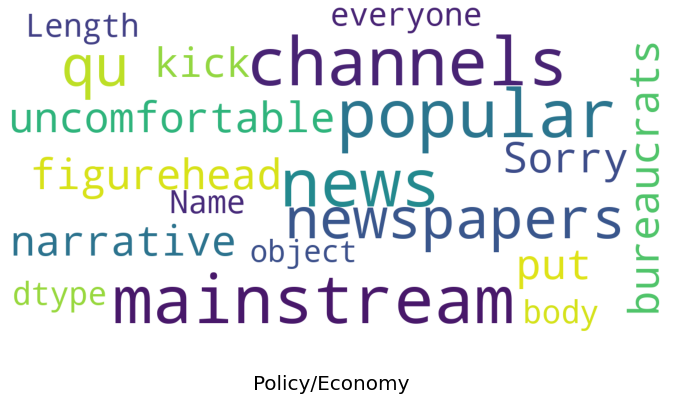

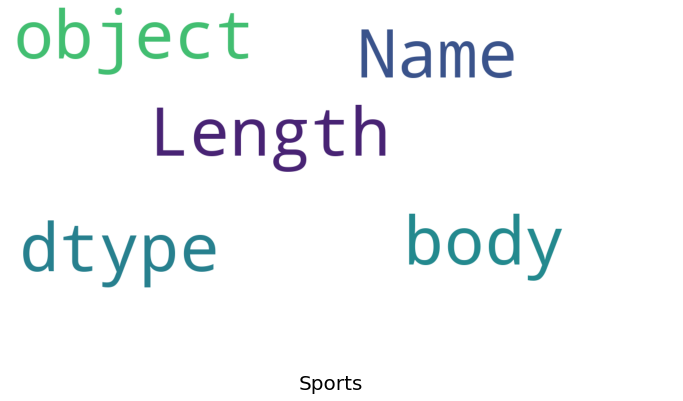

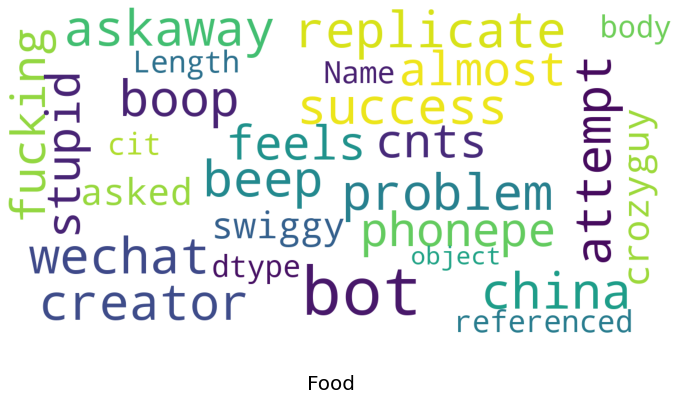

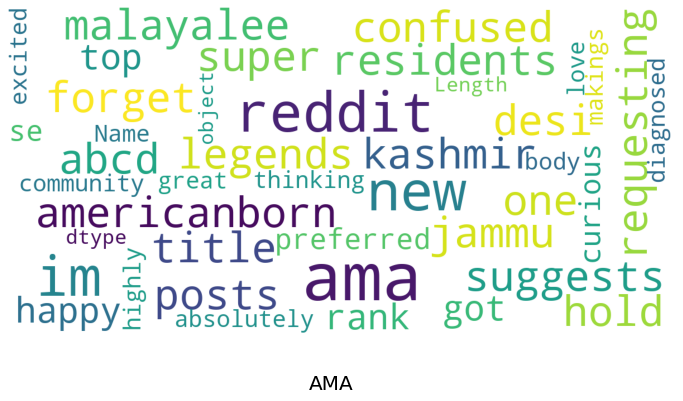

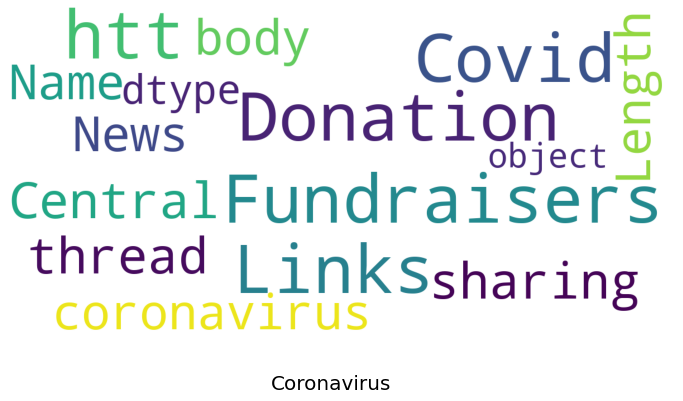

In [38]:
for flair in flairs:
    show_wordcloud(data[data['flair'] == flair]['body'],flair)

This problem is difficult given the ambiguity between different flairs .

**For example :- Frequently occuring words in coronavirus may suggest that the flair is business/finance or vice-versa**

The flair coronavirus has actually a great overlap with many other flairs (in terms of frequently occuring words)like politics,sports,business/finance,policy/economy.

So the machine learning model should focus on relations between words and in what context they are being used .



---






**Number of comments can be varying per post , so to decide what will be a good threshold that will not be too much and at the same time can incorporate all the nescessary information in the model**

Let's see  number of comments per flair 

,comms_num
flair,
AMA,97.091837
AskIndia,41.198830
Business/Finance,26.529070
Coronavirus,226.534137
Food,68.750000
Non-Political,64.031161
Photography,24.571429
Policy/Economy,29.732558
Politics,100.150142


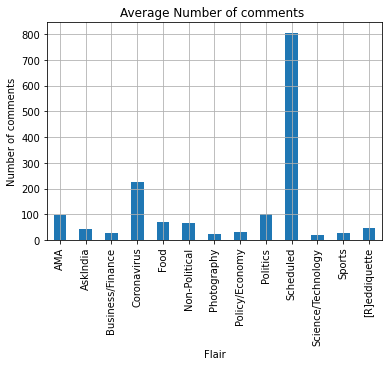

In [39]:


data_copy = data.groupby("flair").mean()[['comms_num']]

data_copy.plot(kind='bar', legend=False, grid=True)

plt.xlabel("Flair")
plt.ylabel("Number of comments")
plt.title("Average Number of comments ")


data_copy.head(13)



let's also see How many posts are there with comments between 0-25

Text(0.5, 1.0, 'Number of comments per post')

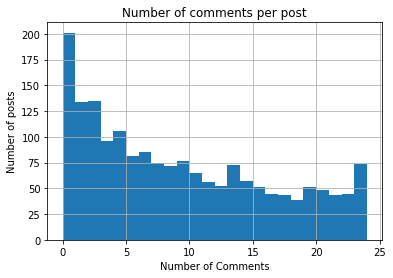

In [40]:
import numpy as np
df = data.comms_num
df.hist(bins = np.arange(0,25,1))

plt.xlabel("Number of Comments")
plt.ylabel("Number of posts")
plt.title("Number of comments per post")


Most of them have close to 20-25 comments and after looking the comments by going to reddit India , it is not a good idea to keep a threshold greater than 20 as after that comments generally do not provide useful information.

A safe threshold will be 15 (ie thinking to keep top 15 comments per flair per post)

**Potential candidates among input for being the features:-**


*   Body and Author
*   Title
*   Comments and Authors

or a combination of them . So to decide whether standalone features will be good or a combination of them .
Let's start by analysing the number of words in body of various posts .





**To see number of posts having given number of words in body**

Text(0.5, 1.0, 'no of words in BODY')

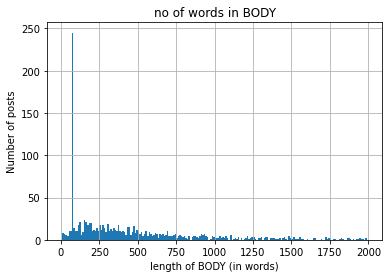

In [41]:



n_words = data.body.str.len()
n_words.hist(bins = np.arange(10,2000,10))
plt.xlabel("length of BODY (in words)")
plt.ylabel("Number of posts")
plt.title("no of words in BODY")





**There are posts with no body so in that case using body as a standalone feature would not be fruitful**



---



**Let's check the same thing  with title**

Text(0, 0.5, 'Number of posts')

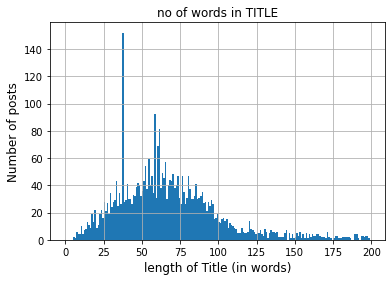

In [43]:
n_title= data.title.str.len()
n_title.hist(bins = np.arange(0,200,1))
plt.title("no of words in TITLE")
plt.xlabel("length of Title (in words)", fontsize=12)
plt.ylabel("Number of posts", fontsize=12)

**It can be inferred that title as a standalone feature would be better than body**
However it provides too little information so various combinations of them should also be tried.



---



**Now let's clean the data and move to flair detection**

Droping duplicates to ensure validation set and training set are mutually exclusive and the reults on validation can be trusted upon 

In [0]:
data.drop_duplicates(subset=['id'], inplace=True)

**Importing necessary libraries for cleaning data and downloading nltk corpus of STOPWORDS**

In [46]:
import nltk



from bs4 import BeautifulSoup
import re
import nltk
from nltk.corpus import stopwords



nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

**clean_text function that would be called later on each column of dataframe except flair**

In [0]:
replace_by_space = re.compile('[/(){}\[\]\|@,;]')
replace_symbol = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = replace_by_space.sub(' ', text) # replace certain symbols by space in text
    text = replace_symbol.sub('', text) # delete symbols from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove STOPWORDS from text
    return text

In [0]:
data['author'].apply(clean_text)

data['body'].apply(clean_text)
data['comment'].apply(clean_text)
data['comms_num'].apply(clean_text)
data['created'].apply(clean_text)

data['id'].apply(clean_text)
data['score'].apply(clean_text)
data['title'].apply(clean_text)
data['url'].apply(clean_text)


**Now this cleaned data can be used for training.**

**Let's move to Reddit_Flair_Detector.ipynb**